In [1]:
from hcipy import *
import numpy as np
import poke.poke_core as pol
import poke.plotting as plot
from astropy.io import fits
import astropy.units as u
import poppy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# load jones pupil
pth = 'Subaru_M1-M3_750nm.fits'
jones_pupil = fits.open(pth)[0].data

# load scexao pupil
pupil_pth = 'scexao_pupil.fits'
pupil_data = fits.open(pupil_pth)[0].data

# Reclaim the complex numbers from the fits file ;-;
J11 = jones_pupil[:,:,0,0,0] + 1j*jones_pupil[:,:,0,0,1]
J12 = jones_pupil[:,:,0,1,0] + 1j*jones_pupil[:,:,0,1,1]

J21 = jones_pupil[:,:,1,0,0] + 1j*jones_pupil[:,:,1,0,1] 
J22 = jones_pupil[:,:,1,1,0] + 1j*jones_pupil[:,:,1,1,1] 

J11 *= pupil_data
J12 *= pupil_data
J21 *= pupil_data
J22 *= pupil_data

<ipython-input-3-573e4f499af1>:2: RuntimeWarning: invalid value encountered in true_divide
  plot.PlotJonesArray(J11*E[0]/pupil_data,J12*E[1]/pupil_data,J21*E[0]/pupil_data,J22*E[1]/pupil_data)


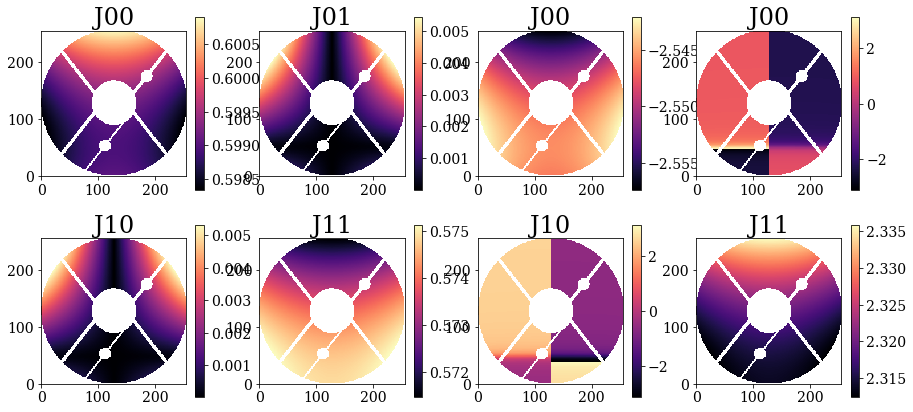

In [3]:
E = np.array([1,1j])/np.sqrt(2)
plot.PlotJonesArray(J11*E[0]/pupil_data,J12*E[1]/pupil_data,J21*E[0]/pupil_data,J22*E[1]/pupil_data)

In [4]:
pupil_grid = make_pupil_grid(256)
focal_grid = make_focal_grid(4, 20)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

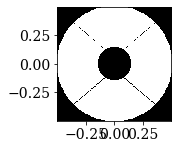

In [5]:
# aperture = J11*pupil_data # make_magellan_aperture(True)
# telescope_pupil = J11*pupil_data# aperture(pupil_grid)
aperture = make_magellan_aperture(True)
telescope_pupil = aperture(pupil_grid)
imshow_field(telescope_pupil, cmap='gray')
plt.show()

<ipython-input-35-45ea0695e74f>:10: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(wavefront.amplitude.shaped/pupil_data)
<ipython-input-35-45ea0695e74f>:14: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(fully_polarized_wavefront.amplitude.shaped/pupil_data)


TypeError: Invalid shape (2, 2, 256, 256) for image data

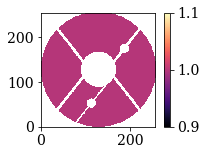

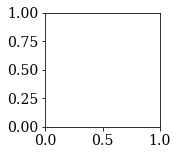

In [35]:
# Try a polarized wavefront
jones = Field([[J11.ravel() , J12.ravel()],[J21.ravel() , J22.ravel()]], pupil_grid) # Circular Light Incident
jones = Field([[J11.ravel() , J12.ravel()],[J21.ravel() , J22.ravel()]], pupil_grid) # Circular Light Incident
stokes = [1,0,0,0]
scalar = Field(pupil_data.ravel(), pupil_grid)

wavefront = Wavefront(scalar)
fully_polarized_wavefront = Wavefront(jones,input_stokes_vector=stokes)

plt.figure()
plt.imshow(wavefront.amplitude.shaped/pupil_data)
plt.colorbar()

plt.figure()
plt.imshow(fully_polarized_wavefront.amplitude.shaped/pupil_data)
plt.colorbar()

# imshow_field(fully_polarized_wavefront.amplitude)


# Optimization Parameters

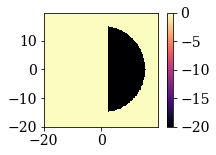

In [36]:
contrast_level = 1e-20

dark_zone = (circular_aperture(30)(focal_grid)).astype(bool)*(focal_grid.x>2)

contrast = focal_grid.ones()

contrast[dark_zone] = contrast_level

imshow_field(np.log10(contrast))
plt.colorbar()
plt.show()

In [37]:
def plot_vapp(vAPP, prop, niter):
    '''Plot the phase pattern and PSF of a vAPP

    Parameters
    ---------
    vAPP : Wavefront
        The wavefront of a vAPP mask, containing the vAPP pattern as phase and
        the telescope pupil as amplitude
    prop : Function
        A propagator function that propagates the wavefront to a focal plane
    '''

    # Plotting the phase pattern and the PSF
    fig = plt.figure(figsize=[10,5])
    plt.suptitle('num iterations = {}'.format(niter))
    ax1 = fig.add_subplot(121)
    im1 = imshow_field(vAPP.phase, mask=vAPP.amplitude, cmap='RdBu')

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    ax2 = fig.add_subplot(122)
    im2 = imshow_field(np.log10(prop(vAPP).intensity/np.max(prop(vAPP).intensity)),vmin = -10, cmap='inferno')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    plt.show()

In [38]:
# Setting up the vAPP calculation parameters.
num_iterations = 1000

In [39]:
# Generate the vAPP pattern.
vAPP = generate_app_keller(fully_polarized_wavefront, prop, contrast, num_iterations, beta = 1)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 25600

In [18]:
# Generate the vAPP pattern.
vAPP_scalar = generate_app_keller(wavefront, prop, contrast, num_iterations, beta = 1)

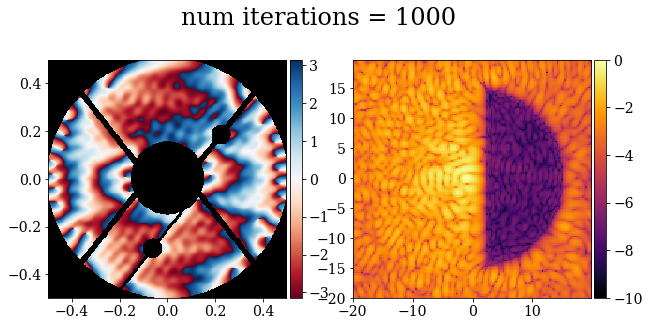

In [22]:
plot_vapp(vAPP, prop, num_iterations)

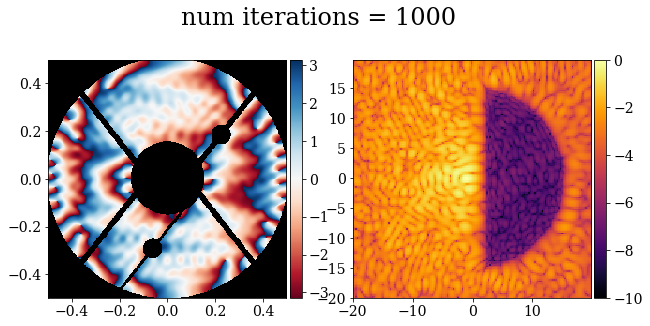

In [23]:
plot_vapp(vAPP_scalar, prop, num_iterations)